# Diagnosing Breast Cancer with K-Nearest Neighbors (KNN)

## 1) Absract: Framing the Problem

Breast cancer is the most prevalent cancer among women globally, accounting for 25% of all cancer cases. In 2015 alone, it impacted over 2.1 million individuals. The disease begins when cells in the breast grow uncontrollably, forming tumors that can be detected via X-ray or felt as lumps.

The biggest challenge is detecting a tumor as malignant (cancerous) or benign (non-cancerous). This project uses KNN to classify tumors given data about the tumor (e.g. compactness, concavity, smoothness). 

## 2) Introduction: What is K-Nearest Neighbors (KNN)?

K-Nearest Neighbors (KNN) predicts by looking at the closest examples in your training data. When given a new case to classify (called a test point), it calculates the distance between this test point and all training examples based on their features, finds the K closest examples (where K is a number you choose, like 3 or 5), and assigns the most common label among these neighbors.

It's like asking for restaurant recommendations in a new neighborhood -- you'd probably trust the opinions of people who live closest to you since they're most similar to your situation and know the local spots best.

The algorithm uses the following steps to classify a given prediction:

1. **Compute the Distance**:
   Decide on a distance metric (e.g., Euclidean distance) beforehand. For each data point *i* in the training set, calculate the distance between the test point and every feature vector *j*:
   $$d(x_{\text{test}}, x_i) = \sqrt{\sum_{j=1}^n (x_{\text{test}, j} - x_{i, j})^2} = \| x_{\text{test}} - x_i \|_2$$
   where:
   - *$x_{\text{test}}$* is the test point.
   - *$x_{\text{i}}$* is a training point.
   - *j* is a feature.
   - *n* is the number of features.

2. **Repeat for All Points**:
   Perform the distance calculation for all \(i\) points in the training dataset. Once we've set our $k$ in k-nearest neighbors, the ones that are closest will be the ones we use.

3. **Calculate Conditional Probabilities**:
   For each class label \(y\), calculate the conditional probability that the test point belongs to that label given the k-nearest neighbors:
   $$P(y = j \mid \text{k}) = \sum_{i=1}^k \mathbb{I}(y_i = j)$$
   where:
   - $\mathbb{I}(y_i = j)$ is the indicator function, which equals 1 if $y_i = j$ (the neighbor belongs to label *j* and 0 otherwise.
   - *k* is the number of neighbors.

4. **Choose the Label with Maximum Probability**:
   Select the label *j* that maximizes the conditional probability:
   $$\hat{y} = \arg\max_{j} P(y = j \mid \text{k})$$
   The test point is assigned the class label corresponding to the highest conditional probability.

Let's go through an example.

In [1]:
import numpy as np
import pandas as pd

We'll gather some data and split between features and labels.

In [2]:
features = [[1, 2], [3, 4], [5, 6]]
labels = [1, 2, 1]

# Convert features list to numpy array and create DataFrame
features_array = np.array(features)
df = pd.DataFrame(features_array, columns=['feature1', 'feature2'])

# Add labels column
df['label'] = labels
print(df)

   feature1  feature2  label
0         1         2      1
1         3         4      2
2         5         6      1


Now, let's grab a test point to classify.

In [3]:
x_test = np.array([10, 12])

We'll use the euclidean distance between that point with all other points and their features.

In [4]:
features = df.drop('label', axis=1)
for i in range(len(df)):
    dist = np.linalg.norm(x_test-features.iloc[i])
    df.loc[i, 'dist'] = dist 
    
print(df)

   feature1  feature2  label       dist
0         1         2      1  13.453624
1         3         4      2  10.630146
2         5         6      1   7.810250


Most importantly, we'll specify the $k$ in k-nearest neighbors to decide *which* neighbors we should use for our algorithm.

That $k$ is 1.

Finally, we calculate and choose the label by adding up how many points in our dataset are closest. Let's keep in mind that we have set $k$ to 1, so it's the label a count of 1 that is closest. 

Usually, a label will be close to more than 1 neighbor, and it's the label with the most neighbors.

In mathematical terms, this is the label with the maximum (conditional) probability as our classification.

In [6]:
# First sort the dataframe by distance to get nearest neighbor
df_sorted = df.sort_values('dist')

# For k=1, we only look at the first row (nearest neighbor)
nearest_label = df_sorted.iloc[0]['label']

# Create indicator function
def indicator(nearest_label):
    label_1 = 0  # Use integers instead of lists
    label_2 = 0
    
    if nearest_label == 1:
        label_1 = 1
    elif nearest_label == 2:
        label_2 = 1
        
    return {1: label_1, 2: label_2}  # Return a dictionary mapping labels to counts

# Get the counts
label_counts = indicator(nearest_label)

# Find the label with maximum count
classification = max(label_counts, key=label_counts.get)

print(f"Label counts: {label_counts}")
print(f"Classification: {classification}")

Label counts: {1: 1, 2: 0}
Classification: 1


Our point should be classified with the label "1" according to KNN.

## 3) Methodology: What Do We Know About the Data?

### Gathering the Data

Data is sourced from the Breast Cancer Wisconsin (Diagnostic) [Dataset](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic), which can be found on [Kaggle](https://www.kaggle.com/datasets/rahmasleam/breast-cancer/data).

The dataset consists of 569 records.

In [27]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rahmasleam/breast-cancer") # Breast Cancer: https://www.kaggle.com/datasets/rahmasleam/breast-cancer/data

print("Path to dataset files:", path)

Path to dataset files: /Users/alexdubro/.cache/kagglehub/datasets/rahmasleam/breast-cancer/versions/1


### Importing the Necessary Packages

Scikit-Learn will do all the heavy lifting that was laid out in the theory. We need to decide on which $k$, however, fits this problem.

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [46]:
dataset_path = os.path.join(path, 'breast-cancer.csv')

raw_data = pd.read_csv(dataset_path)
raw_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Cleaning/preprocessing the Data

We know that M is "Malignant" and B is "Benign." Let's turn those into our label by assigning:
- M = 1
- B = 0

In [30]:
raw_data['diagnosis'] = raw_data['diagnosis'].map({'M': 1, 'B': 0})

We have to remove null data and duplicates as well.

In [31]:
# 1) Removing null data

raw_data.dropna(inplace=True)

# 2) Removing duplicates

raw_data.drop_duplicates(inplace=True)

Let's split the dataset up into training and test sets. The training set can be used to predict each test point, as we discussed in the theory. Since KNN is an instance-based algorithm, the test points will be evaluated on a case-by-case basis.

In [52]:
features = raw_data.drop(['diagnosis'], axis=1)
label = raw_data['diagnosis']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=10)

Because of the sheer difference in size between each column's values (i.e. one column's values might be in thousands; another in decimals), let's standardize the values.

In [34]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Now, to run KNN, we have to set $k$.

Let's try accuracy and the F1 score to determine what $k$ should be.

In [35]:
def accuracy_knn(X_train, X_test, y_train, y_test, max_k=50):
    train_scores = []
    test_scores = []
    
    for k in range(1, max_k + 1):
        # Create and train KNN classifier
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        # Get predictions for both train and test sets
        train_pred = knn.predict(X_train)
        test_pred = knn.predict(X_test)
        
        # Calculate F1 scores
        train_score = accuracy_score(y_train, train_pred)
        test_score = accuracy_score(y_test, test_pred)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    return train_scores, test_scores

train_accuracy_scores, test_accuracy_scores = accuracy_knn(X_train, X_test, y_train, y_test)

In [37]:
# After you get your scores from the accuracy_knn function:
train_accuracy_scores, test_accuracy_scores = accuracy_knn(X_train, X_test, y_train, y_test)

# To find best k and show both scores
for k in range(len(test_accuracy_scores)):
    print(f"k={k+1}: Train accuracy={train_accuracy_scores[k]:.4f}, Test accuracy={test_accuracy_scores[k]:.4f}, "
          f"Difference={abs(train_accuracy_scores[k] - test_accuracy_scores[k]):.4f}")

# Find k with smallest difference and high scores
accuracy_differences = [abs(train - test) for train, test in zip(train_accuracy_scores, test_accuracy_scores)]
best_k = accuracy_differences.index(min(accuracy_differences)) + 1

print(f"\nBest k value (smallest difference): {best_k}")
print(f"Train accuracy: {train_accuracy_scores[best_k-1]:.4f}")
print(f"Test accuracy: {test_accuracy_scores[best_k-1]:.4f}")
print(f"Difference: {accuracy_differences[best_k-1]:.4f}")

k=1: Train accuracy=1.0000, Test accuracy=0.9825, Difference=0.0175
k=2: Train accuracy=0.9648, Test accuracy=0.9737, Difference=0.0088
k=3: Train accuracy=0.9780, Test accuracy=0.9825, Difference=0.0044
k=4: Train accuracy=0.9736, Test accuracy=0.9825, Difference=0.0088
k=5: Train accuracy=0.9780, Test accuracy=0.9912, Difference=0.0132
k=6: Train accuracy=0.9648, Test accuracy=0.9825, Difference=0.0176
k=7: Train accuracy=0.9648, Test accuracy=0.9825, Difference=0.0176
k=8: Train accuracy=0.9604, Test accuracy=0.9825, Difference=0.0220
k=9: Train accuracy=0.9626, Test accuracy=0.9912, Difference=0.0286
k=10: Train accuracy=0.9604, Test accuracy=0.9737, Difference=0.0132
k=11: Train accuracy=0.9626, Test accuracy=0.9912, Difference=0.0286
k=12: Train accuracy=0.9604, Test accuracy=0.9825, Difference=0.0220
k=13: Train accuracy=0.9626, Test accuracy=0.9912, Difference=0.0286
k=14: Train accuracy=0.9538, Test accuracy=0.9825, Difference=0.0286
k=15: Train accuracy=0.9538, Test accuracy=

Using the differences between the accuracy in the training and test sets, the optimal $k$ value is 3.

Let's try the F1 score.

In [38]:
def f1_knn(X_train, X_test, y_train, y_test, max_k=50):
    train_scores = []
    test_scores = []
    
    for k in range(1, max_k + 1):
        # Create and train KNN classifier
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        # Get predictions for both train and test sets
        train_pred = knn.predict(X_train)
        test_pred = knn.predict(X_test)
        
        # Calculate F1 scores
        train_score = f1_score(y_train, train_pred, average='macro')
        test_score = f1_score(y_test, test_pred, average='macro')
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    return train_scores, test_scores

train_f1_scores, test_f1_scores = f1_knn(X_train, X_test, y_train, y_test)

In [39]:
# After you get your scores from the f1_knn function:
train_f1_scores, test_f1_scores = f1_knn(X_train, X_test, y_train, y_test)

# To find best k and show both scores
for k in range(len(test_f1_scores)):
    print(f"k={k+1}: Train F1={train_f1_scores[k]:.4f}, Test F1={test_f1_scores[k]:.4f}, "
          f"Difference={abs(train_f1_scores[k] - test_f1_scores[k]):.4f}")

# Find k with smallest difference and high scores
f1_differences = [abs(train - test) for train, test in zip(train_f1_scores, test_f1_scores)]
best_k = f1_differences.index(min(f1_differences)) + 1

print(f"\nBest k value (smallest difference): {best_k}")
print(f"Train F1 score: {train_f1_scores[best_k-1]:.4f}")
print(f"Test F1 score: {test_f1_scores[best_k-1]:.4f}")
print(f"Difference: {f1_differences[best_k-1]:.4f}")

k=1: Train F1=1.0000, Test F1=0.9805, Difference=0.0195
k=2: Train F1=0.9620, Test F1=0.9702, Difference=0.0082
k=3: Train F1=0.9764, Test F1=0.9803, Difference=0.0039
k=4: Train F1=0.9716, Test F1=0.9803, Difference=0.0086
k=5: Train F1=0.9765, Test F1=0.9902, Difference=0.0137
k=6: Train F1=0.9621, Test F1=0.9803, Difference=0.0182
k=7: Train F1=0.9622, Test F1=0.9803, Difference=0.0181
k=8: Train F1=0.9572, Test F1=0.9803, Difference=0.0231
k=9: Train F1=0.9596, Test F1=0.9902, Difference=0.0306
k=10: Train F1=0.9572, Test F1=0.9702, Difference=0.0130
k=11: Train F1=0.9597, Test F1=0.9902, Difference=0.0305
k=12: Train F1=0.9573, Test F1=0.9803, Difference=0.0229
k=13: Train F1=0.9597, Test F1=0.9902, Difference=0.0305
k=14: Train F1=0.9500, Test F1=0.9803, Difference=0.0303
k=15: Train F1=0.9500, Test F1=0.9803, Difference=0.0303
k=16: Train F1=0.9499, Test F1=0.9803, Difference=0.0304
k=17: Train F1=0.9499, Test F1=0.9803, Difference=0.0304
k=18: Train F1=0.9499, Test F1=0.9803, D

Accuracy and the F1 score point to optimal $k$ is 3.

We can visualize what this looks like.

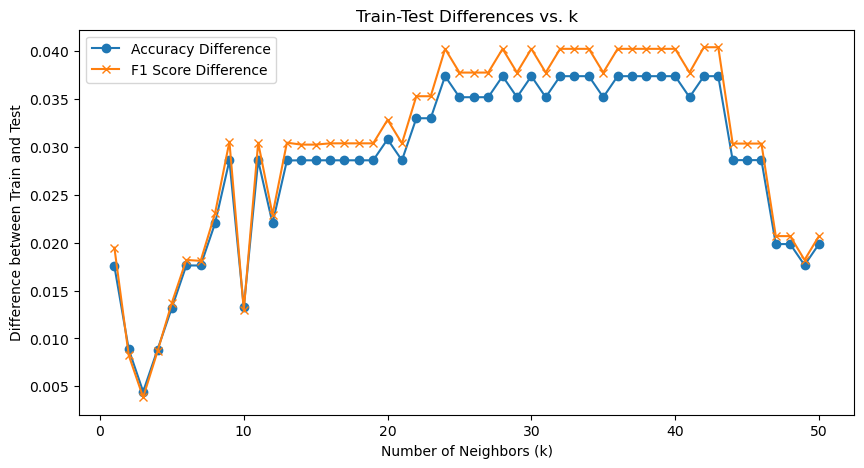

In [40]:
# Plot the differences
plt.figure(figsize=(10, 5))
k_values = range(1, len(accuracy_differences) + 1)
plt.plot(k_values, accuracy_differences, label='Accuracy Difference', marker='o')
plt.plot(k_values, f1_differences, label='F1 Score Difference', marker='x')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Difference between Train and Test')
plt.title('Train-Test Differences vs. k')
plt.legend()
plt.show()

It's always helpful to try proven techniques, so let's see why cross validation says.

Cross-validation shuffles the data into multiple random subsets for training and testing to evaluate a model's accuracy more reliably. To find the optimal $k$ value, cross-validation tests different $k$ values across these data splits and averages their accuracy scores. That will help identify which $k$ produces the most accurate predictions. It's like trying out different-sized focus groups across various neighborhoods to determine the ideal group size that gives the most reliable restaurant recommendations. 

In comparison to taking the differences in accuracy and F1 scores of the training and test sets, cross-validation gives us confidence in our model's ability to generalize to new, unseen data by testing it across different data combinations.

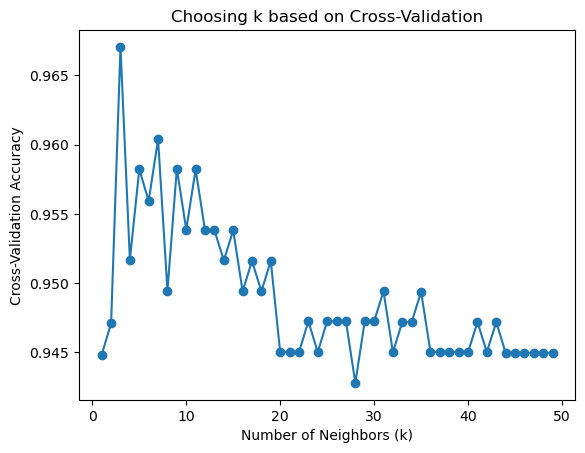

Optimal k: 3


In [41]:
# Range of k values to test
k_values = range(1, 50)
cv_scores = []

# Evaluate cross-validation accuracy for each k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plot results
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Choosing k based on Cross-Validation')
plt.show()

# Best k
best_k = k_values[cv_scores.index(max(cv_scores))]
print(f"Optimal k: {best_k}")

Our best $k$ is 3!

## 4) Findings/Results: Analysis Using KNN 

Let's make classifications on our test set, otherwise known as the holdout data set. This should simulate what classifications should *really* be should we have new data.

Please note that the test set isn’t actually “new” data.

Its performance gives us confidence in how the model might behave when faced with genuinely new data in a real-world deployment.

In [47]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_pred_series = pd.Series(y_pred)
y_pred_series.head()

0    1
1    0
2    0
3    1
4    0
dtype: int64

Nonetheless, we'd still like to know what the new labels would be if we were given *new* data.

Let's simulate.

In [61]:
x = np.random.rand(310)
array = np.array_split(x, 10)
features_sim = pd.DataFrame(array, columns=features.columns)
features_sim.head()

# columns = ['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
#        'smoothness_mean', 'compactness_mean', 'concavity_mean',
#        'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
#        'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
#        'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
#        'fractal_dimension_se', 'radius_worst', 'texture_worst',
#        'perimeter_worst', 'area_worst', 'smoothness_worst',
#        'compactness_worst', 'concavity_worst', 'concave points_worst',
#        'symmetry_worst', 'fractal_dimension_worst']

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.575353,0.536187,0.271331,0.469882,0.249675,0.599724,0.122797,0.829992,0.109233,0.914995,...,0.086593,0.366134,0.448782,0.773564,0.443343,0.735208,0.698613,0.872487,0.577934,0.064917
1,0.192417,0.328014,0.872232,0.648179,0.857040,0.048810,0.186258,0.781657,0.101396,0.381972,...,0.427148,0.330842,0.842317,0.447752,0.430243,0.663974,0.168884,0.765383,0.889259,0.756026
2,0.906815,0.723452,0.235624,0.375311,0.441264,0.445134,0.038390,0.402767,0.959790,0.628883,...,0.941627,0.579522,0.025644,0.639986,0.837572,0.312878,0.323705,0.578636,0.898149,0.190235
3,0.413324,0.577920,0.132695,0.456529,0.278539,0.005601,0.500064,0.393112,0.356573,0.865605,...,0.150800,0.860287,0.050946,0.204764,0.204242,0.899630,0.700769,0.741519,0.764790,0.388047
4,0.682687,0.326054,0.512588,0.945268,0.789661,0.976219,0.474453,0.646476,0.413561,0.621994,...,0.708981,0.914291,0.984962,0.825430,0.953865,0.658331,0.254812,0.973067,0.550246,0.936612


In [59]:
y_pred_sim = knn.predict(X_test)
y_pred_series_sim = pd.Series(y_pred_sim)
y_pred_series_sim.head()

0    1
1    0
2    0
3    1
4    0
dtype: int64

For our simulated data, we've classified whether a tumor would be malignant (1) or benign (0).

### Evaluating Metrics for KNN

We have already determined the **accuracy** and **F1 score**, which helped us determine that the number of neighbors, $k$, should be 3. Now, let’s explore how well our model has done based on other metrics:

#### Metrics Definitions
1. **Accuracy Score**:
   Measures the number of correct predictions divided by the total predictions made.
   
   $$\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}$$
2. **Precision Score**:  
   Measures the proportion of correctly predicted positive observations to the total predicted positives. It indicates how precise the model's positive predictions are.  
   
   $$\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}$$

3. **Recall Score**:  
   Measures the proportion of correctly predicted positive observations to all actual positives. It evaluates the model's ability to capture all relevant cases.  
   
   $$\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}$$

4. **F1 Score**:  
   The harmonic mean of precision and recall. It balances the trade-off between precision and recall, especially when the dataset is imbalanced.  

   $$\text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

In [21]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print results with explanations
print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")


Model Performance Metrics:
Accuracy: 0.9825
Precision (Macro): 0.9870
Recall (Macro): 0.9744
F1 Score (Macro): 0.9803


Our model seems to be doing very well! Its predictions are almost always correct (accuracy), it's pretty correct when identifying True Positives (precision). The same can be said of recall, too, except for False Negatives.

#### Confusion Matrix Overview
We'll include a **confusion matrix** to visualize the classification results.

**Confusion Matrix**:  
   A matrix summarizing the performance of a classification model. It consists of the following components:  
   - **True Positives (TP)**: Correctly predicted positive cases.  
   - **True Negatives (TN)**: Correctly predicted negative cases.  
   - **False Positives (FP)**: Incorrectly predicted positive cases.  
   - **False Negatives (FN)**: Incorrectly predicted negative cases.  

|                     | Predicted Positive | Predicted Negative |
|---------------------|-------------------|-------------------|
| **Actual Positive** | True Positives (TP) | False Negatives (FN) |
| **Actual Negative** | False Positives (FP) | True Negatives (TN) |

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Labels: Actual Positive, Actual Negative")
print(conf_matrix)

Labels: Actual Positive, Actual Negative
[[75  0]
 [ 2 37]]


Very rarely, out of 114 predictions, does it give False Positives: only twice.

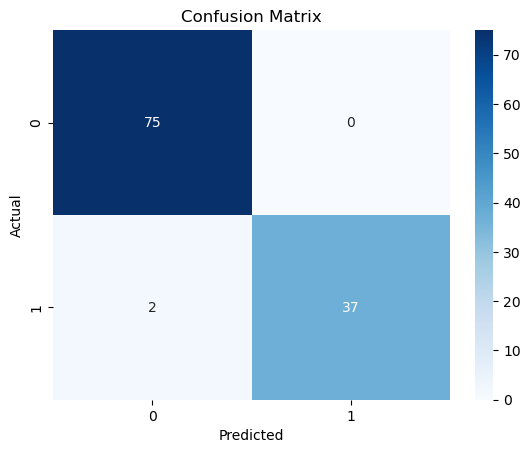

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


#### Classification Report
Finally, we’ll consolidate all the metrics—accuracy, precision, recall, and F1 score—into a **classification report**, which provides a comprehensive summary in a readable format.

In [24]:
class_report = classification_report(y_test, y_pred)
print("\nDetailed Classification Report:")
print(class_report)


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        75
           1       1.00      0.95      0.97        39

    accuracy                           0.98       114
   macro avg       0.99      0.97      0.98       114
weighted avg       0.98      0.98      0.98       114



## 5) Conclusion: KNN Can Predict Breast Cancer

As you might see in the Kaggle code, support vector machine (SVM), logistic regression, XGBoost, and other supervised learning algorithms have successfully predicted and classified breast cancer diagnoses. Most have similar accuracy rates as this paper shows.

But importantly, this paper shows that a much simpler approach to predicting and classifying breast cancer can be done with K-nearest neighbors (KNN), with high accuracy, precision, and recall.